In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.models import TFTModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

from utils import data_loading as dl

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Convert datasets to darts TimeSeries

In [2]:
sunspots = dl.DataLoader(dl.DATASET.SUNSPOTS)
electricity = dl.DataLoader(dl.DATASET.ELECTRICITY)
mackey_glass = dl.DataLoader(dl.DATASET.MACKEY_GLASS)
temperature = dl.DataLoader(dl.DATASET.TEMPERATURE)

electricity.train_df.drop_duplicates(subset="ds", inplace=True)
electricity.val_df.drop_duplicates(subset="ds", inplace=True)


sunspots_series_train = TimeSeries.from_dataframe(sunspots.train_df, "ds", "y")
sunspots_series_val = TimeSeries.from_dataframe(sunspots.val_df, "ds", "y")

electricity_series_train = TimeSeries.from_dataframe(electricity.train_df, "ds", "y", freq="H")
electricity_series_val = TimeSeries.from_dataframe(electricity.val_df, "ds", "y", fill_missing_dates=True, freq="H")

mackey_glass_series_train = TimeSeries.from_dataframe(mackey_glass.train_df, "ds", "y")
mackey_glass_series_val = TimeSeries.from_dataframe(mackey_glass.val_df, "ds", "y")

temperature_series_train = TimeSeries.from_dataframe(temperature.train_df, "ds", "y")
temperature_series_val = TimeSeries.from_dataframe(temperature.val_df, "ds", "y")

series = {
    "sunspots": (sunspots_series_train, sunspots_series_val),
    "electricity": (electricity_series_train, electricity_series_val),
    "mackey_glass": (mackey_glass_series_train, mackey_glass_series_val),
    "temperature": (temperature_series_train, temperature_series_val),
}

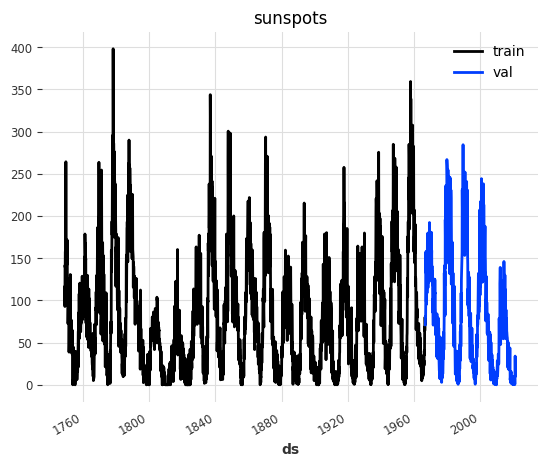

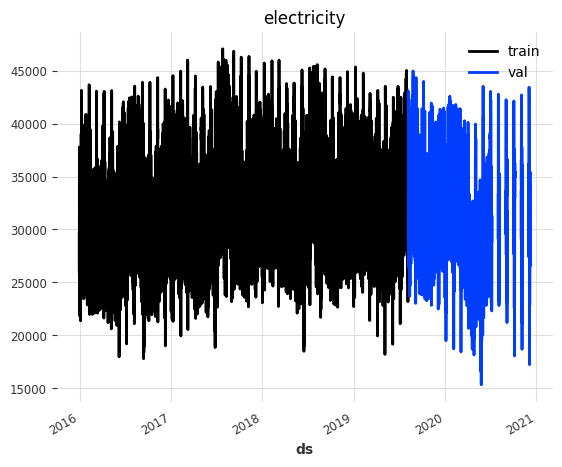

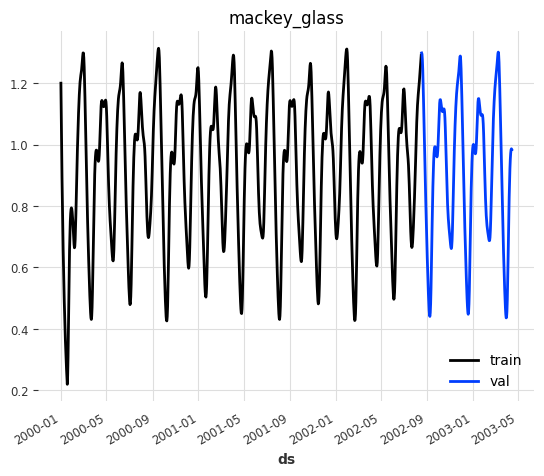

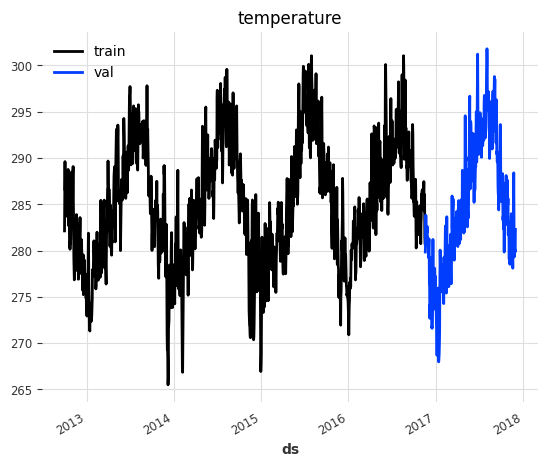

In [4]:
for name, (series_train, series_val) in series.items():
    series_train.plot(label="train")
    series_val.plot(label="val")
    plt.title(name)
    plt.show()

# Preprocessing

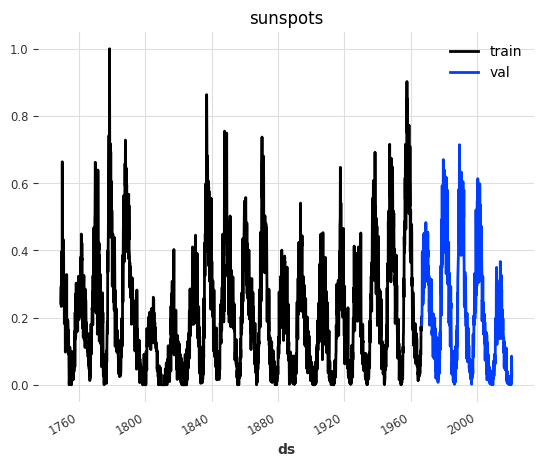

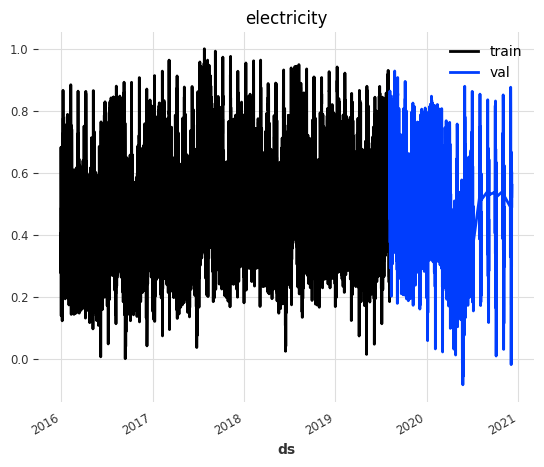

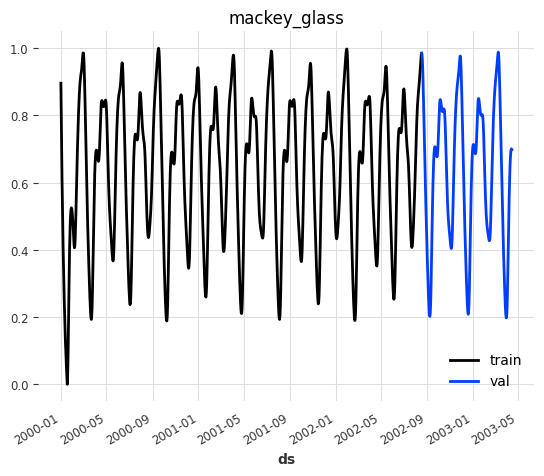

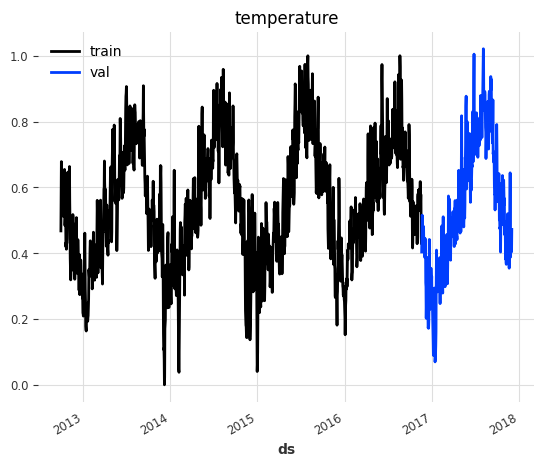

In [5]:
transformer = Scaler()
train_series, val_series = zip(*series.values())
transformer.fit(train_series)

transformed_train_series, transformed_val_series = transformer.transform(train_series), transformer.transform(val_series)
transformed_series = {
    name: (transformed_train_series[i], transformed_val_series[i])
    for i, name in enumerate(series.keys())
}

filler = MissingValuesFiller()
transformed_series = {
    name: (filler.transform(train_series), filler.transform(val_series))
    for name, (train_series, val_series) in transformed_series.items()
}

for name, (series_train, series_val) in transformed_series.items():
    series_train.plot(label="train")
    series_val.plot(label="val")
    plt.title(name)
    plt.show()

# Define model

In [6]:
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 100
forecast_horizon = 1

def get_model():
    model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=forecast_horizon,
        hidden_size=64,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.1,
        batch_size=32,
        n_epochs=300,
        add_relative_index=True,
        add_encoders=None,
        likelihood=QuantileRegression(
            quantiles=quantiles
        ),  # QuantileRegression is set per default
        # loss_fn=MSELoss(),
        random_state=42,
        pl_trainer_kwargs={"accelerator": "cpu"},
        optimizer_kwargs={"lr": 3e-3},
    )
    return model

# Fit model and save weights

In [12]:
def eval_model(model: TFTModel, n, series_val, name, n_samples=10):
    prediction = model.predict(n, num_samples=n_samples)
    prediction.plot(label="prediction")
    series_val[: n].plot(label="actual")
    plt.title(name)
    plt.show()

sunspots
Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


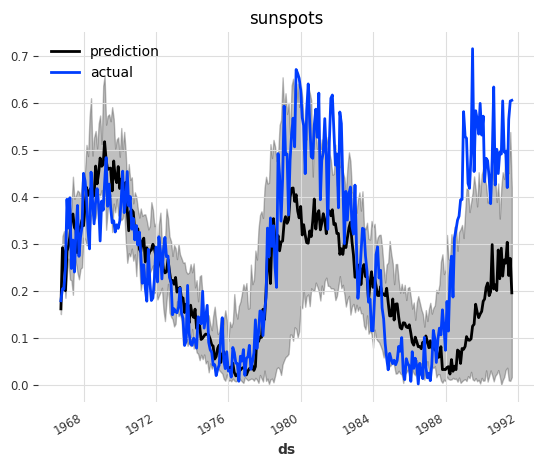

electricity
Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


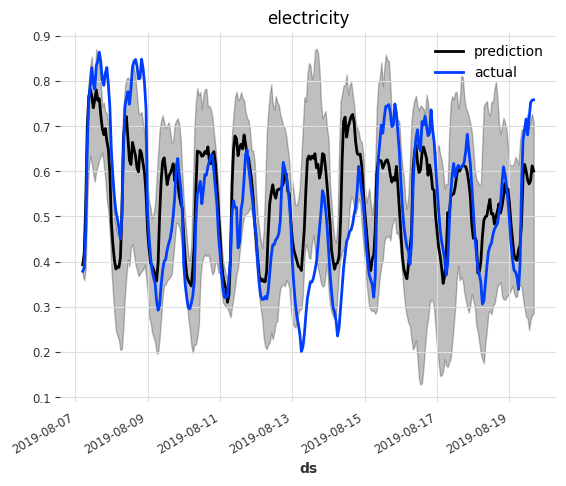

mackey_glass
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


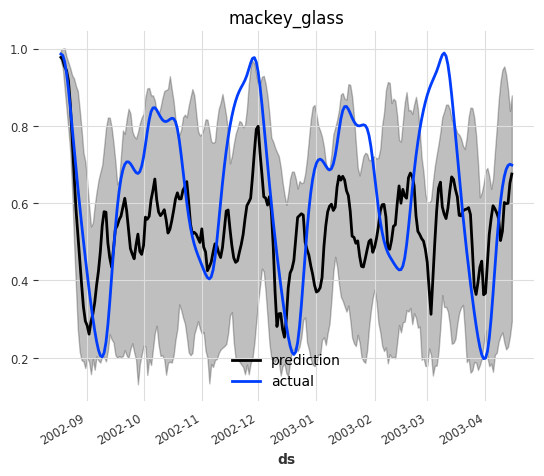

temperature
Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


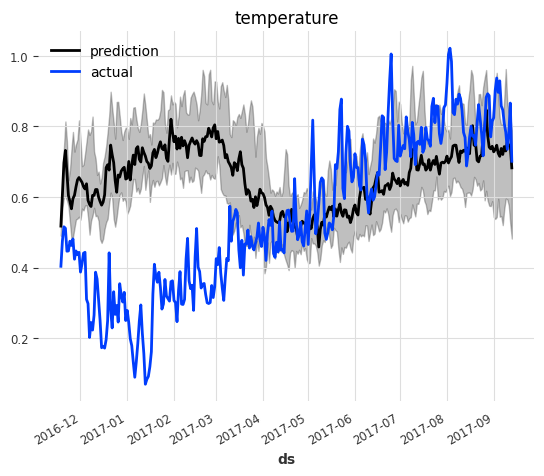

In [8]:
from pathlib import Path
from datetime import datetime
MODEL_DIR = Path().cwd().parent / "models/tft"

for name, (series_train, series_val) in transformed_series.items():
    print(name)
    model = get_model()
    model.fit(series_train, verbose=True, num_loader_workers=0)
    model.save(str(MODEL_DIR / (name + f"{datetime.now().strftime('%H:%M:%S')}")))

    horizon = min(3 * input_chunk_length, len(series_val))
    eval_model(model, horizon, series_val, name)


# Evaluate model

In [10]:
model_electricity = get_model().load(str(MODEL_DIR / "electricity08:06:31"))
model_sunspots = get_model().load(str(MODEL_DIR / "sunspots01:52:41"))
model_mackey_glass = get_model().load(str(MODEL_DIR / "mackey_glass08:16:47"))
model_temperature = get_model().load(str(MODEL_DIR / "temperature08:33:50"))

models = {
    "sunspots": model_sunspots,
    "electricity": model_electricity,
    "mackey_glass": model_mackey_glass,
    "temperature": model_temperature,
}

Predicting DataLoader 0: 100%|██████████| 1/1 [00:50<00:00, 50.95s/it]


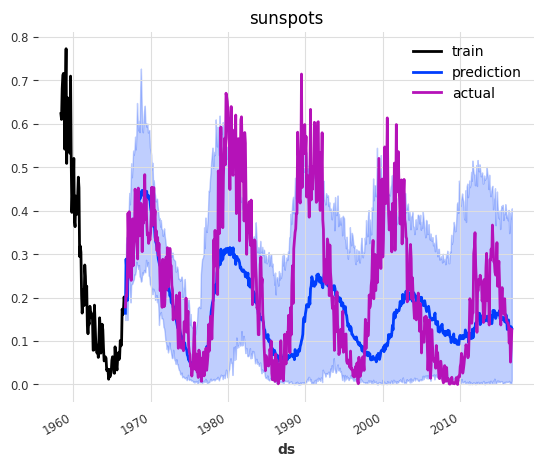

Predicting DataLoader 0: 100%|██████████| 1/1 [00:49<00:00, 49.47s/it]


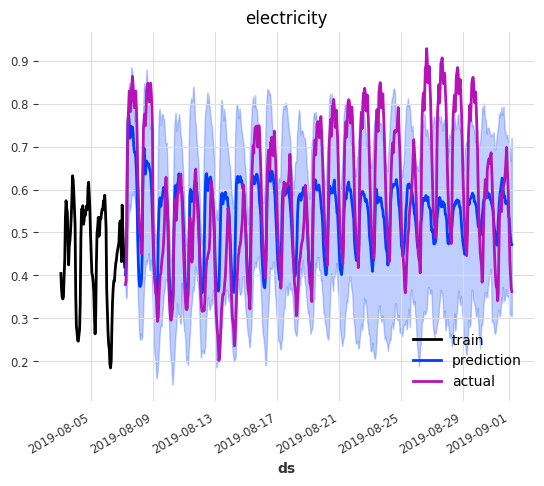

Predicting DataLoader 0: 100%|██████████| 1/1 [00:20<00:00, 20.22s/it]


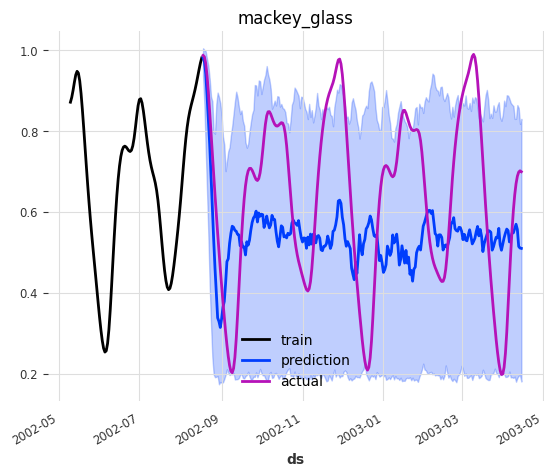

Predicting DataLoader 0: 100%|██████████| 1/1 [00:32<00:00, 32.08s/it]


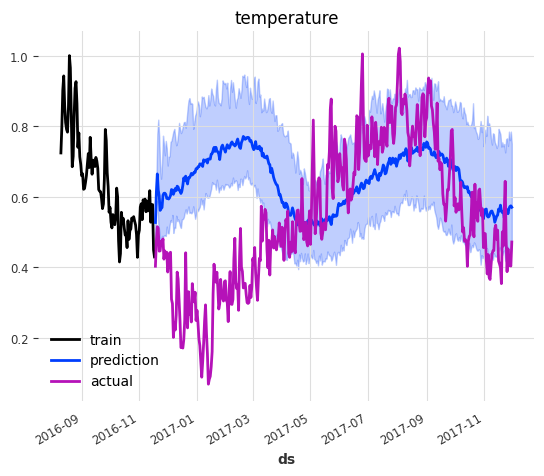

In [15]:
for name, (series_train, series_val) in transformed_series.items():
    horizon = min(6 * input_chunk_length, len(series_val))
    series_train[-input_chunk_length:].plot(label="train")
    eval_model(models[name], horizon, series_val, name, 100)